# ODE based approximation of the Laplace transform
## Idea,ODE, first results

First, some imporst and functions from [Introduction](../1.Introduction.The%20Laplace%20transform.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import odeint
from IPython.display import display, Math
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
#basic functions from introduction
def LaplTrLNIntegrFuncFactory(step=5.5/512.0,n_steps=300):
    bound=(n_steps-1.0)/2.0
    t_nodes=np.arange(-bound*step,(bound+0.5)*step,step)[:,None]#symmetric integration points without 0
    sinh_t=0.5*np.pi*np.sinh(t_nodes)
    sinhsinh_t=np.sinh(sinh_t)
    sinhsinh_t2=sinhsinh_t**2
    dt_mult=0.5*np.pi*(step/np.sqrt(np.pi))*np.cosh(sinh_t)*np.cosh(t_nodes)
    max_exp=int(np.finfo(np.float64).maxexp*np.log(2.))            

    def LaplTrLN(u,v):#direct integration
        '''
        fast version of direct integration
        '''
        s=np.exp(np.sqrt(2.0*v)*sinhsinh_t)*np.atleast_1d(u)[None,:]+sinhsinh_t2
        res=np.sum(np.exp(-s)*dt_mult,axis=0)
        return res
    return LaplTrLN

LaplTrLNFastD=LaplTrLNIntegrFuncFactory()

def LaplTrLNApproxLW(u,v): #simple approximation using lambertw
    theta=u*v
    W=np.real(scsp.lambertw(theta))
    return np.exp(-W*(W+2)/(2*v))/np.sqrt(1+W)

### The idea
We propose a novel method based on constructing ODE (odinary differntial equasions) sets whose solutions approximate $\mathcal{L}_v(u)$.The idea of the method appeared while exploring a disease spread in a non-homogeneous population. In the most simple form, where only two types of population susceptible ($S$) and infectious ($I$) exist, the disease transmission is given by equation:
$$
\begin{align*}
& \frac{dS}{dt} = - c S I , \\[3pt]
&I = 1-S,\\[3pt]
&S(0)=S_0
\end{align*}
$$
here

$c$ - some constant

$S$ - the proportion of the of susceptible population

$I$ - the proportion of the of infectious population

and the equation means that overall attack rate is proportional to the product of susceptible and infectious population.

Let's add the heterogeneity of catching the disease. We will assume that each individual has an innate susceptibility to disease described by the random variable $C$. The probability of an individual catching the disease is therefore proportional to her innate susceptibility $c$. A person's innate susceptibility does not change even if they get the disease. Consequently, we may divide all individuals whose innate susceptibility equals a given value $c$ at a particular time $t$ into two portions: infectious $\mathbf{i}(c,t)$ and still susceptible $\mathbf{s}(c,t)$, where $\mathbf{s}(c,t)+\mathbf{i}(c,t)\equiv1$. At the beginning, $\mathbf{s}(c,0)=1$ and it moves down to zero in time as more and more individuals get infected. If we denote as $\tilde{s}(c,t)=\mathbf{s}(c,t)f_C(c)$ the "density" of the susceptible population (susceptible portion of the total population with the innate susceptibility in the interval $[c,c+dc]$  is $\tilde{s}(c,t)dc$), the total portion of the susceptible population obtained by integrating $\tilde{s}$ over $c$:

$$S(t)=\int_0^{\infty}\tilde{s}(c,t)dc=\int_0^{\infty}\mathbf{s}(c,t)f_C(c)dc=\operatorname{E}[s(C,t)]  \tag{1}$$

Now consider the part of $\tilde{s}(c,t)$ that becomes infectious at the interval $t,t+dt$. This part is proportional to $\tilde{s}(c,t)$ itself, the ability to catch the disease $c$, and the total portion of the **infectious population**. Assuming the proportionality coeffitient equal to 1 we have:
$$d\tilde{s}(c,t)=-c\,\tilde{s}(c,t)I(t)dt=-c\,\tilde{s}(c,t)(1-S(t))dt$$

To continue, we need some crazy disease. For that crazy disease, the part of $\tilde{s}(c,t)$ that becomes infectious is proportional to $\tilde{s}(c,t)$ itself, the ability to catch the disease $c$, and the **susceptible portion** of the population $S(t)$.  The equation above now looks different:

$$d\tilde{s}(c,t)=-c\,\tilde{s}(c,t)S(t)dt\,\,\, \Rightarrow\,\,\, \frac{d\tilde{s}(c,t)}{dt}=-c\,\tilde{s}(c,t)S(t)\tag{2}$$

Or we can just start our explanation with equation (2), assuming it is true for some process.
We can rewite last equation substituting $\tilde{s}(c,t)=\mathbf{s}(c,t)f_C(c)$ 
$$\frac{d\mathbf{s}(c,t)f_C(c)}{dt}=-c\,\mathbf{s}(c,t)f_C(c)S(t)$$


Reducing $f_C(c)$ and taking into account (1) we get
$$\frac{d\mathbf{s}}{dt}=-c\,\mathbf{s}(c,t)S(t)=-c\,\mathbf{s}\,\operatorname{E}[\mathbf{s}(C,t)]$$

Let $\mathbf{s}(c,t)=e^{-c\,u(t)}$, then we have
$$-c\,\mathbf{s}\,\frac{du(t)}{dt}=-c\,\mathbf{s}\,\operatorname{E}[e^{-C\,u(t)}]=-c\,\mathbf{s}\,\mathcal{L}_C(u(t))$$
or
$$\frac{du}{dt}=S(t)=\mathcal{L}_C(u(t))$$

If we take $C \sim LogN(\mu_0,v_0)$ we will have
$$\frac{du}{dt}=S(t)=\mathcal{L}(u(t),\mu_0,v_0) \tag{3}$$
$$u(0)=0,\,S(0)=1$$

We can think of the situation the other way around, and it gives us an approximate solution for equation (3).

In our previous model, we utilized a lognormally distributed variable, denoted as $C$, to characterize the collective ability of **the entire population** to contract the disease. The distribution was constant, with all dynamics encapsulated by $\mathbf{s}(c, t)$. Presently, we employ a lognormally distributed variable, denoted as $X(t)$, to model the ability of **the susceptible population** to contract the disease. Additionally, we need the variable $S(t)$, denoting as previous, the proportion of the susceptible population relative to the entire population. In our new notation

$$ \tilde{s}(x,t) =   f_{X}(x,t)S(t),\tag{4} $$

where $f_{X}(x,t)$ is the probability density function of $X$ at time $t$

Because $\tilde{s}(x,t)$ is the same function as previous  $\tilde{s}(c,t)$, namely $\tilde{s}(x,t)|_{x=c}=\tilde{s}(c,t)$, for given  susceptibility value $a$ it must hold

$$f_{X}(a,t)S(t)=\mathbf{s}(a,t)f_C(a)$$

If we calculate the dynamics of $S(t)$ for the new model, it should be the same as the previous model because it is the dynamics of the same process.

Let us consider a moment in time, $t$, where the lognormal distribution of $X$ has parameters $\mu(t)=E[\log(X(t))]$ and $v(t)=Var[\log(X(t))]$. We aim to compute the new values $\mu(t+dt)=E[\log(X(t+dt))]$ and $v(t+dt)=Var[\log(X(t+dt))]$ at the time $t+dt$. Although the distribution at $t+dt$ will deviate from lognormality, we assume that it adjusts itself to become lognormal with the new parameters $\mu(t+dt)$ and $v(t+dt)$.

From (2)

$$d\tilde{s}(x,t)=-x\, \tilde{s}(x,t)\, S(t)dt=-x\, f_{X}(x)\, S^2(t)dt.\tag{5}$$

As we are interesting specifically in lognormal distributed variable, $f_{X}(x,t)\sim LogN(\mu(t), v(t))$.

### Switching to a normal distribution
It is much more simple to deal with the normal distribution then the lognormal. That's why we make substitution $Y=\ln(X)$ (so $X=e^Y$) and mostly use $Y$ later.

In $Y$ terms we have
$$ s(y,t) =   f_{Y}(y,t)S(t) $$
Vice a versa 

$$f_{Y}(y,t)=\frac{s(y,t)}{S(t)}\tag{6}$$

Here, $f_{Y}(y,t)\sim N(\mu(t), v(t))$.

For $x=e^y$ 
$$\tilde{s}(x,t)=f_{X}(e^y,t)S(t)=\frac{f_{X}(e^y,t)}{f_{Y}(y,t)}f_{Y}(y,t)S(t)=\frac{f_{X}(e^y,t)}{f_{Y}(y,t)}s(y,t)=e^{-y}s(y,t)$$

Because $e^{-y}$ independent of $t$ (5) can be rewritten

$$ds(y,t)=-e^y\, s(y,t)\, S(t)dt=-e^y\, f_{Y}(y)\, S^2(t)dt.$$

### Moments dynamics equations

We start from calculation $s(t+dt)$. 


$$s(y,t+dt)=s(y,t)+ds(y,t)=s(y,t)-e^y\, s(y,t)\, S(t)dt=f_{Y}(y,t)(S-e^y\,S^2\, dt)\tag{7}$$

Integrating it over $y$ we get

$$S(t+dt)= \int_{-\infty}^{\infty}f_{Y}(y,t)(S(t)-e^y\,S(t)^2\, dt)\,dy=S-\operatorname{E}[e^Y(t)]S^2 \,dt=S- M S^2\,dt\tag{8}$$

or

$$\frac{dS}{dt}=- M S^2$$

where $M$ (same as ${}^0\!M$ later) is the function of $t$ : 

$$M(t) =\operatorname{E}[e^{Y(t)}]=\exp\left(\mu(t)+\frac{v(t)}{2}\right).$$

Combinimg (6),(7), and (8)

$$f_{Y}(t+dt)=\frac{s(y,t+dt)}{S(t+dt)}=f_{Y}(y,t)\frac{1-e^y S\, dt}{1- M S\, dt}$$

Up to first order on $dt$ terms 

$$f_{Y}(t+dt)=f_{Y}(t)(1+(M-e^y)Sdt)+o(dt)\tag{9}$$

so

$$\mu(t+dt)=\operatorname{E}\,[Y(t+dt)]=\int_{-\infty}^{\infty}f_{Y}(y,t+dt)y\,dy=\int_{-\infty}^{\infty}f_{Y}(y,t)(1+(M-e^y)Sdt)y\,dy +o(dt)$$

$$=\operatorname{E}\left[(1+(M - e^{Y(t)}) S\,dt)Y(t)\right]+o(dt)=\operatorname{E}[Y](1+MSdt) - \operatorname{E}[Ye^Y]S\,dt+o(dt)\tag{10}$$

Later we need to calculate the expectations $ \operatorname{E}[Y^ie^{Y}]$
for some integer i and random variable $Y$, which we denote ${}^i\!M_{Y}$ or just ${}^i\!M$ (${}^0\!M$ we denote as $M$). We can use following property:

$${}^i\!M_{Y} = \operatorname{E}[Y^ie^{Y}]=\frac{d^i\operatorname{E}[e^{zY}]}{dz^i} \biggr | _1=\frac{d^i\mathcal{M}_Y(z)}{dz^i} \biggr | _1$$
where $\mathcal{M}_Y(z):=\operatorname{E}[e^{zY}]$ is the [Moment-generating function](https://en.wikipedia.org/wiki/Moment-generating_function) (MGF) of Y.

From MGF properties we can find moments $m_i$ of $Y$ as follows
$$m_i=\operatorname{E}[Y^i]=\frac{d^i\mathcal{M}_Y(z)}{dz^i} \biggr | _0$$

In these notations we rewrite (8):
$$\mu(t+dt)=m_1(t+dt)=m_1(t)\left(1+M(t)S(t)dt\right) - {}^1\!M(t)S(t)\,dt+o(dt)=m_1(t)+\left(M(t)m_1(t)-{}^1\!M(t)\right)S(t)dt+o(dt)$$

or 
$$d\mu=dm_1=\left(M(t)m_1(t)-{}^1\!M(t)\right)S(t)dt$$

The same way, it is possible to find expression for differential of any raw momentum of $Y$

$$dm_i=m_i(t+dt)-m_i(t)=\operatorname{E}\left[\left(1+(M - e^{Y(t)}\right) S\,dt){Y(t)}^i\right]-m_i(t)=\left(M(t)m_i(t)-{}^i\!M(t)\right)S(t)dt\tag{11}$$

For the normally distributed $Y \sim N(\mu,v)$ MGF is
$$\mathcal{M}_Y(z)=\exp(\mu z+\frac{vz^2}{2})$$

Finally
$$\mu(t+dt)=\mu(t)-M(t) S(t) v(t)\,dt +o(dt)$$
also omitting some math

$$v(t+dt)=v(t)-M(t) S(t) v^2(t)\,dt +o(dt) $$

As a result, we have the system:

$$M=e^{\mu+v/2}$$
$$\frac{dS}{dt}=-M S^2$$
$$\frac{d\mu}{dt}=-M S v \tag{12}$$
$$\frac{dv}{dt}=-M S v^2$$
$$S(0)=1,\,\mu(0)=\mu_0,\,v(0)=v_0$$

The system has been constructed a way to be close to solution (3). So if $S(t)$ is the solution of (12) we can write:

$$\frac{du}{dt}=\mathcal{L}(u(t),\mu_0,v_0) \approx S(t). \tag{13}$$

### Approximation of $\mathcal{L}(u(t),\mu_0,v_0)$
The problem is we have approximate solution depending on $t$, not $u$. To solve this we rewrite (12)


$$\frac{dS}{du}=-M S^2\frac{dt}{du},$$

$$\frac{d\mu}{du}=-M S v \frac{dt}{du},\tag{14}$$

$$\frac{dv}{du}=-M S v^2\frac{dt}{du},$$

$$S(0)=1,\,\mu(0)=\mu_0,\,v(0)=v_0$$

and from (5) we know
$$ \frac{dt}{du} \approx \frac{1}{S}$$

The idea to substitute this to (14) - it is approximate system anyway, so pretending that 
$$ \frac{dt}{du} = \frac{1}{S}\tag{15}$$
makes approximation little worse. 

Now we get
$$\frac{dS}{du}=-M S,$$

$$\frac{d\mu}{du}=-M v,\tag{16}$$

$$\frac{dv}{du}=-M v^2,$$

$$S(0)=1,\,\mu(0)=\mu_0,\,v(0)=v_0$$

$S(u)$ should be close to $\mathcal{L}(u,\mu_0,v_0)$. Let $L=\ln(S)$ and remember we considering the case $\mu_0=0$ then for $L$ system (16) looks:

$$M=e^{\mu+v/2}$$

$$\frac{dL}{du}=-M,$$

$$\frac{d\mu}{du}=-M v,\tag{17}$$

$$\frac{dv}{du}=-M v^2,$$

$$L(0)=1,\,\mu(0)=0,\,v(0)=v_0$$

$$S=e^L$$



In [3]:
def LaplTrLNODE1(u,v0):# u must start from 0
    def ode(y,t):
        _,mu,v=y
        dL=-np.exp(mu+0.5*v)
        dmu=dL*v
        dv=dmu*v
        return [dL,dmu,dv]
    L,_,_=odeint(ode,[0.0,0.0,v0],u).T
    S=np.exp(L)
    return S

It is possible to reduce the system to one equation. Let $V=1/v$ then $dv/du$ in (17) will be
$$\frac{dV}{du}=M,$$
taking to account $\frac{dL}{du}=-M$ and $L(0)=0$, we get
$$\frac{dL}{du}=-\frac{dV}{du},$$ hence
$$L=V(0)-V.$$
Also, we have
$$\frac{d\mu}{dV}=\frac{d\mu}{du}\frac{du}{dV}=-v=-\frac{1}{V}$$
so 
$$\mu=C-\ln(V)$$
The value of the constant $C$ is given by condition $\mu(0)=0$, hence
$$C=\ln(V(0)),$$
and
$$\frac{dV}{du}=M=\exp(\mu+\frac{v}{2})=\exp(\ln(V(0))-\ln(V)+\frac{1}{2V})=\frac{V(0)}{V}\exp(\frac{1}{2 V}).$$

Finally, the system is

$$V(0)=\frac{1}{v_0},$$

$$\frac{dV}{du}=\frac{V(0)}{V}\exp(\frac{1}{2 V}),$$

$$\mathcal{L}_{v_0}(u) \approx \exp(V(0)-V(u)).$$

In [4]:
def LaplTrLNODE2(u,v0):
    V0=1.0/v0
    def ode(V,t):return V0*np.exp(0.5/V)/V
    y=odeint(ode,V0,u).T
    return np.exp(V0-y[0])

In [5]:
modeling_period=10.0
u_step=0.02
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)

In [6]:
v0=0.75

Cheking the functions give the same result

In [7]:
np.allclose(LaplTrLNODE1(u_r,v0),LaplTrLNODE2(u_r,v0))

True

### Result
See how it is looked like.

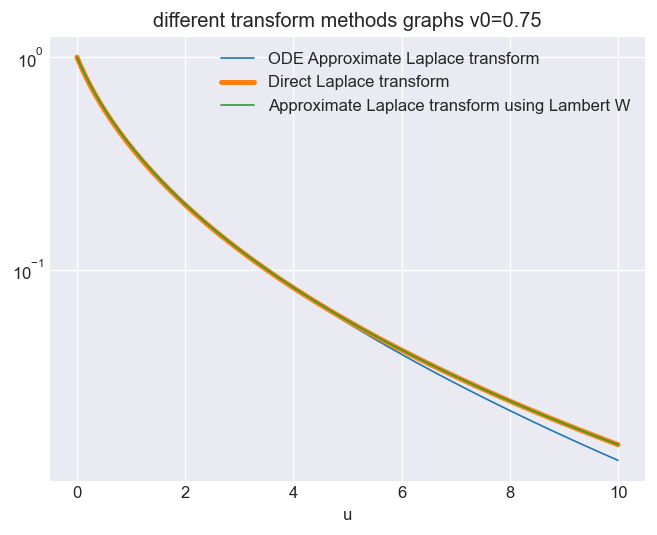

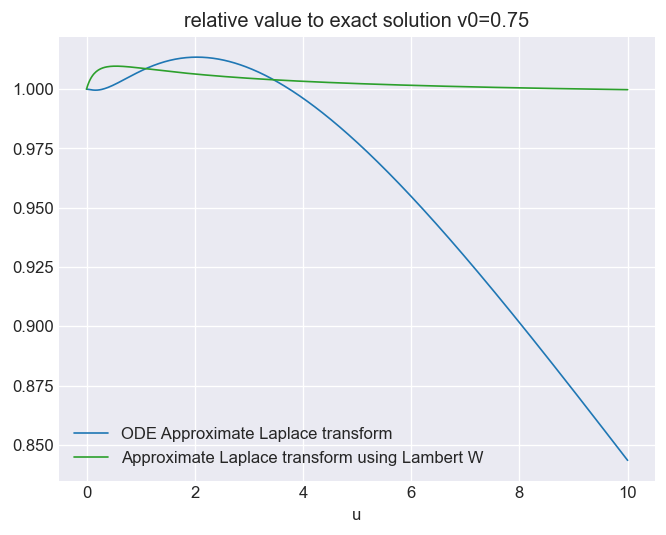

In [8]:
direct=LaplTrLNFastD(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,LaplTrLNODE2(u_r,v0),linewidth=1,color='C0', label=f'ODE Approximate Laplace transform')
plt.plot(u_r,direct, linewidth=3,color='C1', label=f'Direct Laplace transform')
plt.plot(u_r,LaplTrLNApproxLW(u_r,v0),color='C2',linewidth=1, label=f'Approximate Laplace transform using Lambert W')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
plt.plot(u_r,LaplTrLNODE2(u_r,v0)/direct,linewidth=1,color='C0', label=f'ODE Approximate Laplace transform')
plt.plot(u_r,LaplTrLNApproxLW(u_r,v0)/direct,linewidth=1,color='C2', label=f'Approximate Laplace transform using Lambert W')

plt.xlabel('u')
plt.legend(loc='lower left')
plt.show()

Up to $u=1$, the ODE approximation of the $\mathcal{L}_{v_0}(u)$ is quite good but rapidly becomes inaccurate for $u>1$. Can we improve it?

The inaccuracy originates from the imperfection of the normal distribution's approximation of the distribution $f_{Y}(t+dt)$. Better fitting requires the use of a distribution with more parameters $Y'\left(p_1(t),p_2(t),p_3(t),...,p_n(t)\right)$ in order to produce better proximity to $f_{Y}(t+dt)$. Also the distribution needs to be normal at $t=0$.
$$Y'(p_1(0),p_2(0),p_3(0)...,p_n(0)) \sim N(\mu_0,v_0)$$

Next [section](2.2.Sympy%20automation.Skew%20Normal%20Distribution.ipynb) the Skew Normal Distribution (having 3 parameters) will be used. Also sympy scripts to automate the equations inference will be presented.